In [3]:
import os
import re
import tqdm
from glob import glob
from pathlib import Path
import random as rnd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize





In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower().strip()

    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    text = re.sub(r"\b\d+\b", "<NUM>", text)

    words = text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ataha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ataha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def extract_and_clean_code(black_part, code_list, conversation):
    if len(black_part) > 0:
        black_part.contents[0].decompose()
        code = black_part.text
        code_lines = code.split("\n")
        cleaned_code_lines = []
        for line in code_lines:
            if len(line.strip()) != 0 and not line.strip().startswith("#"):
                cleaned_code_lines.append(line)
        cleaned_code = "\n".join(cleaned_code_lines)
                
        code_list.append(cleaned_code)
        
        conversation[0].contents[0].find_all("pre")[0].decompose()

In [6]:
data_path = "html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        fid = os.path.basename(path).split(".")[0]

        html_page = fh.read()

        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                text = convo[0].text
                code_list = []
                black_part = convo[0].find_all("div", class_= "bg-black rounded-md")
                for black_part_n in black_part:
                    code = ""
                    extract_and_clean_code(black_part_n, code_list, convo)
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text,
                        "code" : code_list
                    })
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:10<00:00, 11.62it/s]


In [7]:
def clean_text(text):
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'\s+', ' ', text).strip()
    return text
for history, conversations in code2convos.items():
    for conversation in conversations:
        conversation["text"] = clean_text(conversation.get("text", ""))
        code_lines = conversation.get("code", [])
        conversation["code"] = [clean_text(line) for line in code_lines]

In [8]:
code2convos

{'0031c86e-81f4-4eef-9e0e-28037abf9883': [{'role': 'user',
   'text': "Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'.",
   'code': []},
  {'role': 'assistant',
   'text': "You can load a CSV file into a Pandas DataFrame in Python using the pandas.read_csv() function. Here's how you can do it for your specific CSV file:This code assumes that the CSV file 'cs412_hw1_dataset.csv' is in the same directory as your Python script or Jupyter Notebook. If the file is in a different directory, you can specify the full path to the file in the file_path variable.The pd.read_csv() function will automatically infer the column names from the first row of the CSV file, so you don't need to explicitly specify the column names unless they are different from what you provided. You can ac

# Prompts Matching

In [9]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\W', ' ', text)  
    return text
def extract_user_prompts(conversations):
    return [conv["text"] for conv in conversations if conv["role"] == "user"]

prompts = []
code2prompts = defaultdict(list)

for code, convos in code2convos.items():
    user_prompts = extract_user_prompts(convos)
    prompts.extend(user_prompts) 
    code2prompts[code] = user_prompts 

In [10]:
print(prompts)

["Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'.", 'Provide Python code to understand a dataset using Pandas. Find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.', "You will preprocess the data now 1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing 2. Encode labels with mappings using the map function. Mapping names: - sex_map = {'female': 1, 'male': 0} - island_map = {'Biscoe': 1, 'Dream': 2, 'Torgensen': 3} - diet_map = {'fish': 1, 'krill': 2, 'squid': 3, 'parental': 4} - life_stage_m

In [11]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80%\ and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [12]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_text) 
vectorizer = vectorizer.fit(prompts + questions)

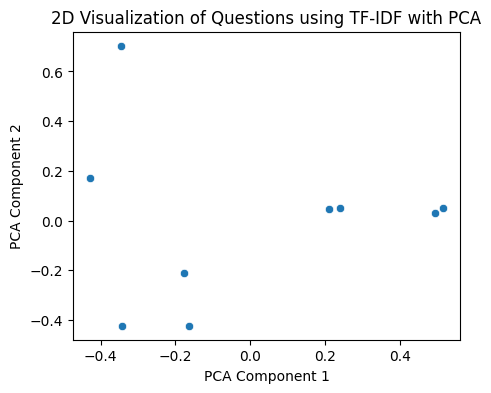

In [13]:
tf_idf_matrix = vectorizer.transform(questions).toarray()

pca = PCA(n_components=2)  
reduced_features = pca.fit_transform(tf_idf_matrix)

reduced_df = pd.DataFrame(reduced_features, columns=['PCA1', 'PCA2'])

plt.figure(figsize=(5, 4))
sns.scatterplot(data=reduced_df, x='PCA1', y='PCA2')
plt.title("2D Visualization of Questions using TF-IDF with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [14]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

00000  000000  000196  000282  000284  000360  000469  000750  000886  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   000991  ...  youve  ypred  yticklabels  yticks  zaman  zdm  zero  \
0     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
1     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
2     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
3     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
4     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   

   zerodivisionerror  zeroth  zip  
0                0.0     0.0  0.0  
1                0.0     0.0  0.0  
2                0.0     0.0  0.0  
3                0.0     0.0  0.0  
4                0.0     0.0  0.0  

[5 rows x 5361 columns]

In [15]:
code2prompts_TF_IDF = dict()
codes_with_no_prompts = []

for code, user_prompts in code2prompts.items():
    if not user_prompts:  
        print(f"{code}.html")
        codes_with_no_prompts.append(code)
        continue

    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_TF_IDF[code] = prompts_TF_IDF

example_code = "089eb66d-4c3a-4f58-b98f-a3774a2efb34"
print(code2prompts_TF_IDF[example_code].shape)
code2prompts_TF_IDF[example_code].head()

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
(86, 5361)


00000  000000  000196  000282  000284  000360  000469  000750  000886  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   000991  ...  youve  ypred  yticklabels  yticks  zaman  zdm  zero  \
0     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
1     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
2     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
3     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
4     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   

   zerodivisionerror  zeroth  zip  
0                0.0     0.0  0.0  
1                0.0     0.0  0.0  
2                0.0     0.0  0.0  
3                0.0     0.0  0.0  
4                0.0     0.0  0.0  

[5 rows x 5361 columns]

In [16]:
code2prompts_TF_IDF["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

00000  000000  000196  000282  000284  000360  000469  000750  000886  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   000991  ...  youve  ypred  yticklabels  yticks  zaman  zdm  zero  \
0     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
1     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
2     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
3     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   
4     0.0  ...    0.0    0.0          0.0     0.0    0.0  0.0   0.0   

   zerodivisionerror  zeroth  zip  
0                0.0     0.0  0.0  
1                0.0     0.0  0.0  
2                0.0     0.0  0.0  
3                0.0     0.0  0.0  
4                0.0     0.0  0.0  

[5 rows x 5361 columns]

In [17]:
code2prompts_TF_IDF["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5361)

In [18]:
code2cosine = dict()
for code, user_prompts_TF_IDF in code2prompts_TF_IDF.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_TF_IDF))

In [19]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [20]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

code       Q_0       Q_1       Q_2  \
0    0031c86e-81f4-4eef-9e0e-28037abf9883  0.153582  0.294878  0.522162   
1    0225686d-b825-4cac-8691-3a3a5343df2b  0.192067  0.795607  0.772174   
2    041f950b-c013-409a-a642-cffff60b9d4b  0.258378  0.295921  0.624849   
3    04f91058-d0f8-4324-83b2-19c671f433dc  0.146047  0.117834  0.267381   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.344280  0.575528  0.782873   
..                                    ...       ...       ...       ...   
118  f24219d6-07f0-4baf-80ac-18475dc5b66f  0.187470  0.209888  0.358883   
119  f2f18684-4a16-4c05-a2d1-c0f96d1de869  0.144801  0.139495  0.332274   
120  f852596d-fdca-45aa-9050-d4f76ce6a53c  0.211060  0.908697  0.977726   
121  f8ec3336-fd48-4654-ad98-62ccfb96d096  0.173262  0.967321  1.000000   
122  fb8de815-224c-4d06-9fd4-7156d1a9920d  0.170342  0.712409  0.835224   

          Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  
0    0.352245  0.460602  0.553879  0.167269  0.182931  0.195440  
1    0.882656  0.607118  0.987511  0.892586  0.570733  0.544839  
2    0.351870  0.643034  0.454330  0.540284  0.546518  0.325791  
3    0.316809  0.333889  0.314856  0.192434  0.261892  0.407217  
4    0.624833  0.724877  0.872171  0.684798  0.945305  0.512526  
..        ...       ...       ...       ...       ...       ...  
118  0.211246  0.149289  0.507131  1.000000  0.862585  0.739730  
119  0.950344  0.775707  0.828352  0.374145  0.905688  0.553340  
120  0.924311  0.888609  0.921307  0.779558  0.767328  0.500262  
121  0.703984  0.942662  0.907415  1.000000  1.000000  0.783744  
122  0.760650  0.895230  0.943543  0.944887  0.844004  0.730284  

[123 rows x 10 columns]

# Feature Engineering


In [21]:
code2features = defaultdict(lambda: defaultdict(int))
keywords2search = ["error", "no", "thank", "next", "Entropy", "hata", "sorun", "anlamıyorum"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    total_prompts = total_responses = 0
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            code2features[code]["#user_prompts"] += 1
            total_prompts += len(text)
            for kw in keywords2search:
                code2features[code][f"#{kw}"] += len(re.findall(rf"\b{kw}\b", text))
        else:
            total_responses += len(text)

    code2features[code]["prompt_avg_chars"] = total_prompts / code2features[code]["#user_prompts"] if code2features[code]["#user_prompts"] > 0 else 0
    code2features[code]["response_avg_chars"] = total_responses / code2features[code]["#user_prompts"] if code2features[code]["#user_prompts"] > 0 else 0



139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [22]:
df = pd.DataFrame(code2features).T
df.head(4)

#user_prompts  #error  #no  #thank  \
0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   

                                      #next  #entropy  #hata  #sorun  \
0031c86e-81f4-4eef-9e0e-28037abf9883    0.0       0.0    0.0     0.0   
0225686d-b825-4cac-8691-3a3a5343df2b    0.0       3.0    0.0     0.0   
041f950b-c013-409a-a642-cffff60b9d4b    0.0       3.0    0.0     0.0   
04f91058-d0f8-4324-83b2-19c671f433dc    0.0       3.0    0.0     0.0   

                                      #anlamıyorum  prompt_avg_chars  \
0031c86e-81f4-4eef-9e0e-28037abf9883           0.0        405.071429   
0225686d-b825-4cac-8691-3a3a5343df2b           0.0        252.000000   
041f950b-c013-409a-a642-cffff60b9d4b           0.0        644.777778   
04f91058-d0f8-4324-83b2-19c671f433dc           0.0        107.050000   

                                      response_avg_chars  
0031c86e-81f4-4eef-9e0e-28037abf9883         1061.142857  
0225686d-b825-4cac-8691-3a3a5343df2b          992.555556  
041f950b-c013-409a-a642-cffff60b9d4b          613.444444  
04f91058-d0f8-4324-83b2-19c671f433dc          962.550000

In [23]:
scores = pd.read_csv("scores.csv", sep=",", converters={'code': lambda x: x.strip()})

selected_columns = ['code', 'grade']
scores = scores[selected_columns]

scores.head(10)

code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
5  dd898b12-b04b-404e-9b59-f846a162c177   98.0
6  dd898b12-b04b-404e-9b59-f846a162c177   98.0
7  b0640e51-6879-40cb-a4f5-329f952ef99d   98.0
8  668ad17e-0240-49f7-b5a7-d22e502554c6   99.0
9  ba18e4e8-2c26-46d4-ba31-cc21947aabd5  100.0

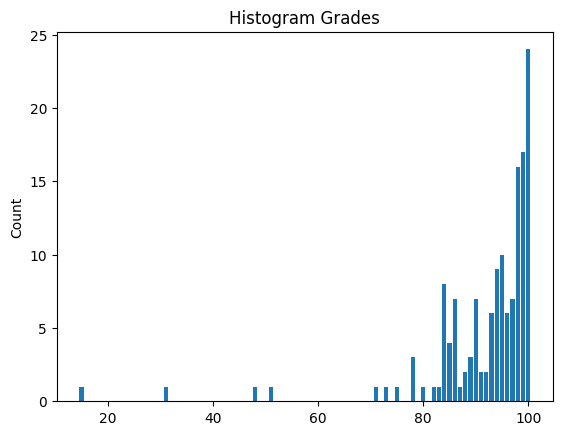

In [24]:
plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

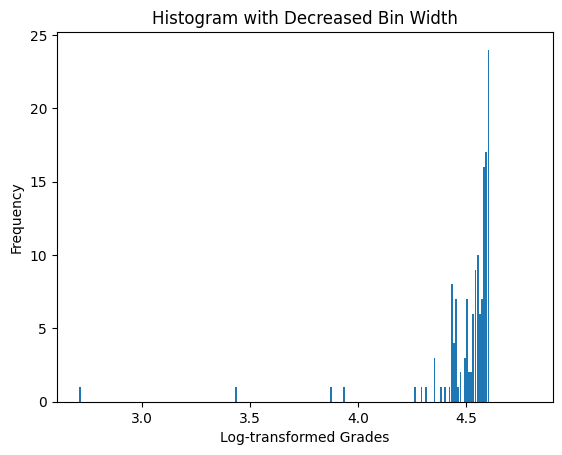

In [25]:
log_transformed_grades = np.log(scores["grade"])
plt.hist(log_transformed_grades, rwidth=0.8, bins=np.arange(min(log_transformed_grades), max(log_transformed_grades)+0.2, 0.01))
plt.title('Histogram with Decreased Bin Width')
plt.xlabel('Log-transformed Grades')
plt.ylabel('Frequency')
plt.show()

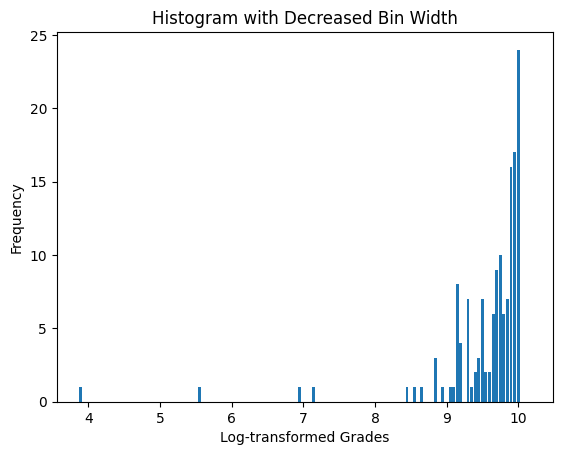

In [26]:
sqrt_transformed_grades = np.sqrt(scores["grade"])
plt.hist(sqrt_transformed_grades, rwidth=0.8, bins=np.arange(min(sqrt_transformed_grades), max(sqrt_transformed_grades)+0.2, 0.05))
plt.title('Histogram with Decreased Bin Width')
plt.xlabel('Log-transformed Grades')
plt.ylabel('Frequency')
plt.show()

In [27]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  #hata  #sorun  #anlamıyorum  prompt_avg_chars  \
0    0.0       0.0    0.0     0.0           0.0        405.071429   
1    0.0       3.0    0.0     0.0           0.0        252.000000   
2    0.0       3.0    0.0     0.0           0.0        644.777778   
3    0.0       3.0    0.0     0.0           0.0        107.050000   
4    0.0      26.0    0.0     0.0           0.0        206.453488   

   response_avg_chars  
0         1061.142857  
1          992.555556  
2          613.444444  
3          962.550000  
4          762.883721

In [28]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  #hata  #sorun  #anlamıyorum  ...  response_avg_chars  \
0    0.0       0.0    0.0     0.0           0.0  ...         1061.142857   
1    0.0       3.0    0.0     0.0           0.0  ...          992.555556   
2    0.0       3.0    0.0     0.0           0.0  ...          613.444444   
3    0.0       3.0    0.0     0.0           0.0  ...          962.550000   
4    0.0      26.0    0.0     0.0           0.0  ...          762.883721   

        Q_0       Q_1       Q_2       Q_3       Q_4       Q_5       Q_6  \
0  0.153582  0.294878  0.522162  0.352245  0.460602  0.553879  0.167269   
1  0.192067  0.795607  0.772174  0.882656  0.607118  0.987511  0.892586   
2  0.258378  0.295921  0.624849  0.351870  0.643034  0.454330  0.540284   
3  0.146047  0.117834  0.267381  0.316809  0.333889  0.314856  0.192434   
4  0.344280  0.575528  0.782873  0.624833  0.724877  0.872171  0.684798   

        Q_7       Q_8  
0  0.182931  0.195440  
1  0.570733  0.544839  
2  0.546518  0.325791  
3  0.261892  0.407217  
4  0.945305  0.512526  

[5 rows x 21 columns]

#### Merging scores with features

In [29]:
temp_df = (
    pd.merge(df, scores, on='code', how='left')
    .dropna()
    .drop_duplicates('code', keep='first')
)

temp_df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  #hata  #sorun  #anlamıyorum  ...       Q_0       Q_1  \
0    0.0       0.0    0.0     0.0           0.0  ...  0.153582  0.294878   
1    0.0       3.0    0.0     0.0           0.0  ...  0.192067  0.795607   
2    0.0       3.0    0.0     0.0           0.0  ...  0.258378  0.295921   
3    0.0       3.0    0.0     0.0           0.0  ...  0.146047  0.117834   
4    0.0      26.0    0.0     0.0           0.0  ...  0.344280  0.575528   

        Q_2       Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  grade  
0  0.522162  0.352245  0.460602  0.553879  0.167269  0.182931  0.195440   48.0  
1  0.772174  0.882656  0.607118  0.987511  0.892586  0.570733  0.544839   99.0  
2  0.624849  0.351870  0.643034  0.454330  0.540284  0.546518  0.325791   90.0  
3  0.267381  0.316809  0.333889  0.314856  0.192434  0.261892  0.407217   97.0  
4  0.782873  0.624833  0.724877  0.872171  0.684798  0.945305  0.512526  100.0  

[5 rows x 22 columns]

In [30]:
temp_df_regular = pd.merge(df, scores, on="code", how="left")
temp_df_regular.dropna(inplace=True)
temp_df_regular.drop_duplicates("code", inplace=True, keep="first")
temp_df_regular.head()

temp_df_sorted_regular = temp_df_regular.sort_values(by="grade", ascending=False)

print(temp_df_sorted_regular)

                                     code  #user_prompts  #error  #no  #thank  \
47   51f35201-da77-4b6d-a455-99cc84195c5c           13.0     0.0  0.0     3.0   
128  e264c424-a241-43f7-acca-9fbbf21dc1c6           35.0     3.0  4.0     0.0   
75   745bb746-6467-4146-8ef5-55f3ee3f589e           28.0     2.0  0.0     0.0   
26   27de4332-d81f-47a2-b2a9-c0b023a30919           21.0     0.0  0.0     0.0   
82   7b0ecddc-caa5-4b81-88ea-cd65a7270900           22.0     0.0  1.0     0.0   
..                                    ...            ...     ...  ...     ...   
37   42980d53-7bcd-4a36-bf3a-aa43f7417ac5           13.0     2.0  1.0     0.0   
121  da219169-aacb-48b8-abdc-e25f08ad029e           15.0     0.0  0.0     0.0   
0    0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
58   5e481e20-f714-4f11-b941-0ef2fd5976d3            1.0     0.0  0.0     0.0   
132  e8fd2278-1620-432d-81cb-02cac8543456           14.0     0.0  0.0     0.0   

     #next  #entropy  #hata

#### Train

In [31]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)


(122, 20) (122,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [33]:
regressor = DecisionTreeRegressor(random_state=0, criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [34]:
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R-Kare (R²) Değeri: {r2:.2f}")

R-Kare (R²) Değeri: -0.26


In [35]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Ortalama Kare Hata (MSE): {mse:.2f}")
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f}")

Ortalama Kare Hata (MSE): 141.17
Ortalama Mutlak Hata (MAE): 6.90


In [36]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 167.02777777777737
Node 4 has MSE 83.96484375
Node 5 has MSE 4.222222222222626
Node 6 has MSE 1.0
Node 7 has MSE 0.0
Node 8 has MSE 0.0
Node 9 has MSE 0.0
Node 10 has MSE 43.846153846154266
Node 11 has MSE 0.6666666666660603
Node 12 has MSE 0.25
Node 13 has MSE 0.0
Node 14 has MSE 0.22222222222262644
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 23.551020408162913
Node 19 has MSE 12.6875
Node 20 has MSE 0.0
Node 21 has MSE 4.66666666666697
Node 22 has MSE 0.25
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 8.0
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 100.0
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 27.533240997230678
Node 33 has MSE 25.170927684439448
Node 34 has MSE 22.85062487601499
Node 35 has MSE 6.888888888887777
Node 36 has MSE 0.25
Node 37 has MSE 0.0
Node 38 has MSE 0.0
Node 39 

In [37]:
temp_df

code  #user_prompts  #error  #no  #thank  \
0    0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1    0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2    041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3    04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   
..                                    ...            ...     ...  ...     ...   
135  f24219d6-07f0-4baf-80ac-18475dc5b66f           21.0     1.0  0.0     0.0   
136  f2f18684-4a16-4c05-a2d1-c0f96d1de869           71.0     1.0  1.0     1.0   
137  f852596d-fdca-45aa-9050-d4f76ce6a53c           30.0     6.0  1.0     0.0   
138  f8ec3336-fd48-4654-ad98-62ccfb96d096           14.0     0.0  0.0     0.0   
139  fb8de815-224c-4d06-9fd4-7156d1a9920d           31.0     8.0  0.0     2.0   

     #next  #entropy  #hata  #sorun  #anlamıyorum  ...       Q_0       Q_1  \
0      0.0       0.0    0.0     0.0           0.0  ...  0.153582  0.294878   
1      0.0       3.0    0.0     0.0           0.0  ...  0.192067  0.795607   
2      0.0       3.0    0.0     0.0           0.0  ...  0.258378  0.295921   
3      0.0       3.0    0.0     0.0           0.0  ...  0.146047  0.117834   
4      0.0      26.0    0.0     0.0           0.0  ...  0.344280  0.575528   
..     ...       ...    ...     ...           ...  ...       ...       ...   
135    0.0       4.0    0.0     0.0           0.0  ...  0.187470  0.209888   
136    1.0       6.0    0.0     0.0           0.0  ...  0.144801  0.139495   
137    4.0       3.0    0.0     0.0           0.0  ...  0.211060  0.908697   
138    1.0       3.0    0.0     0.0           0.0  ...  0.173262  0.967321   
139    0.0       7.0    0.0     0.0           0.0  ...  0.170342  0.712409   

          Q_2       Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  \
0    0.522162  0.352245  0.460602  0.553879  0.167269  0.182931  0.195440   
1    0.772174  0.882656  0.607118  0.987511  0.892586  0.570733  0.544839   
2    0.624849  0.351870  0.643034  0.454330  0.540284  0.546518  0.325791   
3    0.267381  0.316809  0.333889  0.314856  0.192434  0.261892  0.407217   
4    0.782873  0.624833  0.724877  0.872171  0.684798  0.945305  0.512526   
..        ...       ...       ...       ...       ...       ...       ...   
135  0.358883  0.211246  0.149289  0.507131  1.000000  0.862585  0.739730   
136  0.332274  0.950344  0.775707  0.828352  0.374145  0.905688  0.553340   
137  0.977726  0.924311  0.888609  0.921307  0.779558  0.767328  0.500262   
138  1.000000  0.703984  0.942662  0.907415  1.000000  1.000000  0.783744   
139  0.835224  0.760650  0.895230  0.943543  0.944887  0.844004  0.730284   

     grade  
0     48.0  
1     99.0  
2     90.0  
3     97.0  
4    100.0  
..     ...  
135   93.0  
136  100.0  
137   98.0  
138  100.0  
139   98.0  

[122 rows x 22 columns]

In [38]:
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("graph")

'graph.pdf'

In [39]:
optimal_regressor = DecisionTreeRegressor(
    max_depth=50,
    max_features='log2',
    min_samples_leaf=4,
    min_samples_split=5
)
optimal_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=50, max_features='log2', min_samples_leaf=4,
                      min_samples_split=5)

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt', None]  # 'auto' kaldırıldı
}

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("En İyi Parametreler:", grid_search.best_params_)
print("En İyi Skor:", -grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
En İyi Parametreler: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
En İyi Skor: 161.62842105263155


In [42]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [43]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

rf_y_pred = rf_regressor.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest R^2: {rf_r2}")

Random Forest MSE: 114.15411600000002
Random Forest R^2: -0.01682185816492332
